# Exploratory Data Analysis and Preprocessing
## Non-Technical Loss Detection Pipeline

**Document Type:** Technical Analysis Report  
**Audience:** Data Scientists, ML Engineers, Technical Reviewers  
**Prerequisites:** Review 00_Project_Context_and_Problem_Definition.ipynb  

---

### Objective

This notebook performs data validation, quality assessment, and feature engineering for the NTL detection pipeline. All transformations are deterministic and versioned for reproducibility.

### Outputs

- `artifacts/preprocessed.parquet` - Feature matrix for modeling
- `artifacts/pipeline_v1.joblib` - Serialized preprocessing pipeline
- `artifacts/feature_schema.json` - Feature specifications and metadata

In [9]:
# Standard library imports
import sys
import json
import hashlib
from pathlib import Path
from datetime import datetime
import warnings

# Data processing
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Add backend to path for preprocessing utilities
sys.path.insert(0, str(PROJECT_ROOT / 'src' / 'backend'))

print(f'Project Root: {PROJECT_ROOT}')
print(f'Data Directory: {DATA_DIR}')
print(f'Artifacts Directory: {ARTIFACTS_DIR}')
print(f'Execution Time: {datetime.now().isoformat()}')

Project Root: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein
Data Directory: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\data
Artifacts Directory: c:\Users\MadScie254\Documents\GitHub\Capstone-Einstein\Capstone-Einstein\artifacts
Execution Time: 2025-12-16T02:18:35.284987


## 1. Data Ingestion and Validation

### 1.1 Schema Verification

Expected data format:
- Each row represents one customer meter
- Columns contain daily consumption readings (kWh)
- `CONS_NO`: Unique customer/meter identifier
- `FLAG`: Binary label (0 = normal, 1 = confirmed theft) where available

In [10]:
# Load dataset
data_file = DATA_DIR / 'datasetsmall.csv'
df_raw = pd.read_csv(data_file)

print('=== DATA INGESTION SUMMARY ===')
print(f'Source file: {data_file.name}')
print(f'Total records: {len(df_raw):,}')
print(f'Total columns: {len(df_raw.columns)}')
print(f'Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.2f} MB')

=== DATA INGESTION SUMMARY ===
Source file: datasetsmall.csv
Total records: 25,863
Total columns: 28
Memory usage: 7.89 MB


In [11]:
# Identify column types
metadata_cols = ['CONS_NO', 'FLAG']
consumption_cols = [c for c in df_raw.columns if c not in metadata_cols]

print(f'\n=== COLUMN STRUCTURE ===')
print(f'Metadata columns: {metadata_cols}')
print(f'Consumption columns: {len(consumption_cols)}')
print(f'Date range: {consumption_cols[0]} to {consumption_cols[-1]}')

# Validate expected columns exist
missing_cols = [c for c in metadata_cols if c not in df_raw.columns]
if missing_cols:
    print(f'WARNING: Missing expected columns: {missing_cols}')
else:
    print('Schema validation: PASSED')


=== COLUMN STRUCTURE ===
Metadata columns: ['CONS_NO', 'FLAG']
Consumption columns: 26
Date range: 01/01/2014 to 1/26/2014
Schema validation: PASSED


In [12]:
# Label distribution analysis
if 'FLAG' in df_raw.columns:
    label_counts = df_raw['FLAG'].value_counts().sort_index()
    theft_ratio = df_raw['FLAG'].mean()
    
    print('\n=== LABEL DISTRIBUTION ===')
    print(f'Normal (FLAG=0): {label_counts.get(0, 0):,}')
    print(f'Theft (FLAG=1): {label_counts.get(1, 0):,}')
    print(f'Theft ratio: {theft_ratio:.2%}')
    print(f'Class imbalance ratio: 1:{int(1/theft_ratio) if theft_ratio > 0 else "inf"}')
else:
    print('WARNING: No label column found. Unsupervised methods only.')


=== LABEL DISTRIBUTION ===
Normal (FLAG=0): 23,741
Theft (FLAG=1): 2,122
Theft ratio: 8.20%
Class imbalance ratio: 1:12


### 1.2 Missingness Analysis

Understanding data gaps is critical for:
- Imputation strategy selection
- Feature reliability assessment
- Identifying potential meter communication issues

In [13]:
# Convert consumption columns to numeric, coercing errors
df = df_raw.copy()
for col in consumption_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate missingness
consumption_matrix = df[consumption_cols].values
missing_count = np.isnan(consumption_matrix).sum()
total_values = consumption_matrix.size
missing_pct = missing_count / total_values * 100

print('=== MISSINGNESS ANALYSIS ===')
print(f'Total values: {total_values:,}')
print(f'Missing values: {missing_count:,}')
print(f'Missing percentage: {missing_pct:.2f}%')

=== MISSINGNESS ANALYSIS ===
Total values: 672,438
Missing values: 125
Missing percentage: 0.02%


In [14]:
# Per-customer missingness
missing_per_customer = df[consumption_cols].isna().sum(axis=1)
n_days = len(consumption_cols)

print('\n=== PER-CUSTOMER MISSINGNESS ===')
print(f'Customers with complete data: {(missing_per_customer == 0).sum():,}')
print(f'Customers with any missing: {(missing_per_customer > 0).sum():,}')
print(f'Customers with >50% missing: {(missing_per_customer > n_days * 0.5).sum():,}')
print(f'Average missing days per customer: {missing_per_customer.mean():.2f}')
print(f'Maximum missing days: {missing_per_customer.max()}')


=== PER-CUSTOMER MISSINGNESS ===
Customers with complete data: 25,822
Customers with any missing: 41
Customers with >50% missing: 0
Average missing days per customer: 0.00
Maximum missing days: 12


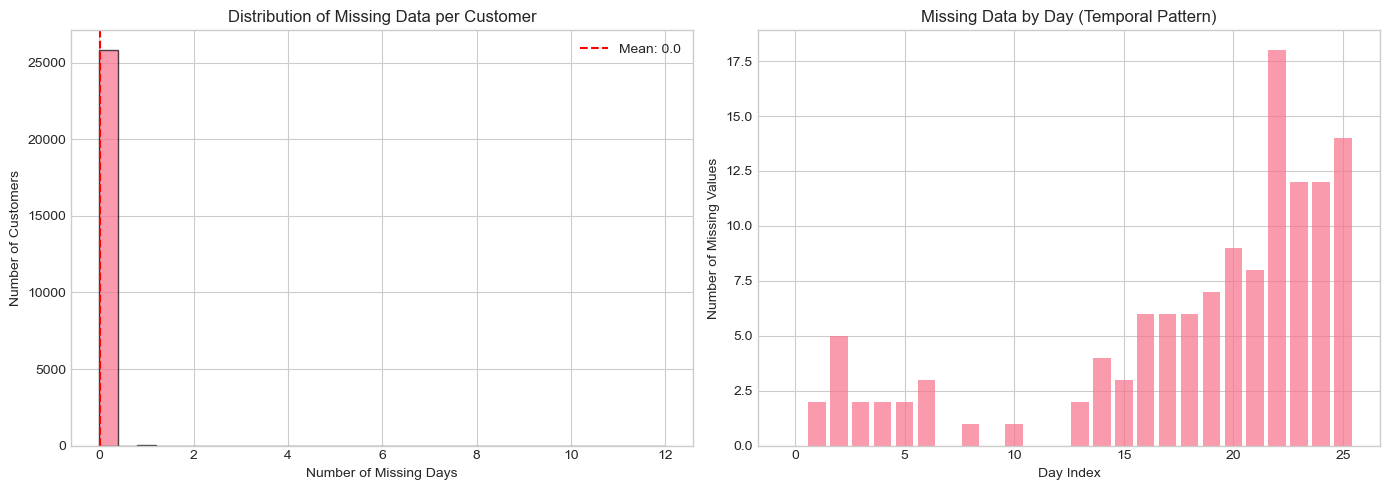

Figure saved: missingness_analysis.png


In [15]:
# Visualize missingness distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of missing days per customer
axes[0].hist(missing_per_customer, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(missing_per_customer.mean(), color='red', linestyle='--', label=f'Mean: {missing_per_customer.mean():.1f}')
axes[0].set_xlabel('Number of Missing Days')
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Distribution of Missing Data per Customer')
axes[0].legend()

# Missing by day (temporal pattern)
missing_by_day = df[consumption_cols].isna().sum(axis=0)
axes[1].bar(range(len(missing_by_day)), missing_by_day, alpha=0.7)
axes[1].set_xlabel('Day Index')
axes[1].set_ylabel('Number of Missing Values')
axes[1].set_title('Missing Data by Day (Temporal Pattern)')

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'missingness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('Figure saved: missingness_analysis.png')

## 2. Consumption Pattern Analysis

### 2.1 Zero and Near-Zero Consumption

Zero consumption readings warrant special attention:
- **Legitimate:** Vacation, unoccupied property, meter maintenance
- **Suspicious:** Extended zeros in occupied buildings, post-intervention zeros

In [16]:
# Zero consumption analysis
zero_threshold = 0.01  # kWh - readings below this considered zero
consumption_values = df[consumption_cols].values.astype(float)

# Count zeros per customer
zeros_per_customer = np.sum(consumption_values < zero_threshold, axis=1)
zeros_per_customer[np.isnan(consumption_values).all(axis=1)] = np.nan  # Handle all-NaN rows

print('=== ZERO CONSUMPTION ANALYSIS ===')
print(f'Zero threshold: {zero_threshold} kWh')
print(f'Customers with any zero days: {(zeros_per_customer > 0).sum():,}')
print(f'Customers with >5 zero days: {(zeros_per_customer > 5).sum():,}')
print(f'Average zero days per customer: {np.nanmean(zeros_per_customer):.2f}')

ValueError: cannot convert float NaN to integer

In [ ]:
# Compare zero rates between normal and theft groups
if 'FLAG' in df.columns:
    normal_zeros = zeros_per_customer[df['FLAG'] == 0]
    theft_zeros = zeros_per_customer[df['FLAG'] == 1]
    
    print('\n=== ZERO DAYS BY CLASS ===')
    print(f'Normal customers - mean zero days: {np.nanmean(normal_zeros):.2f}')
    print(f'Theft customers - mean zero days: {np.nanmean(theft_zeros):.2f}')
    print(f'Ratio (theft/normal): {np.nanmean(theft_zeros) / np.nanmean(normal_zeros):.2f}x')
    
    # Statistical test
    stat, pvalue = stats.mannwhitneyu(normal_zeros[~np.isnan(normal_zeros)], 
                                       theft_zeros[~np.isnan(theft_zeros)])
    print(f'Mann-Whitney U test p-value: {pvalue:.2e}')
    print(f'Conclusion: {"Significant difference" if pvalue < 0.05 else "No significant difference"}')

### 2.2 Consumption Distribution Comparison

Visual comparison of consumption patterns between classes provides intuition for feature engineering.

In [ ]:
# Calculate summary statistics per customer
df['consumption_mean'] = df[consumption_cols].mean(axis=1)
df['consumption_std'] = df[consumption_cols].std(axis=1)
df['consumption_cv'] = df['consumption_std'] / (df['consumption_mean'] + 1e-10)

# Visualize distributions by class
if 'FLAG' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    metrics = ['consumption_mean', 'consumption_std', 'consumption_cv']
    titles = ['Mean Daily Consumption (kWh)', 'Std Dev of Consumption (kWh)', 'Coefficient of Variation']
    
    for ax, metric, title in zip(axes, metrics, titles):
        for flag, label, color in [(0, 'Normal', '#2E86AB'), (1, 'Theft', '#E94F37')]:
            subset = df[df['FLAG'] == flag][metric].dropna()
            ax.hist(subset, bins=50, alpha=0.6, label=label, color=color, density=True)
        ax.set_xlabel(title)
        ax.set_ylabel('Density')
        ax.set_title(f'Distribution: {title}')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / 'consumption_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Figure saved: consumption_distributions.png')

### 2.3 Temporal Pattern Examples

Visualizing individual consumption profiles helps build intuition for normal vs. suspicious patterns.

In [ ]:
# Sample and plot consumption profiles
np.random.seed(42)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Sample normal customers
normal_sample = df[df['FLAG'] == 0].sample(3, random_state=42)
for idx, (ax, (_, row)) in enumerate(zip(axes[0], normal_sample.iterrows())):
    consumption = row[consumption_cols].values.astype(float)
    days = range(len(consumption))
    ax.plot(days, consumption, color='#2E86AB', linewidth=1.5)
    ax.fill_between(days, consumption, alpha=0.3, color='#2E86AB')
    ax.axhline(np.nanmean(consumption), color='gray', linestyle='--', alpha=0.5)
    ax.set_title(f'Normal Customer {idx+1}', fontsize=11)
    ax.set_xlabel('Day')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_ylim(bottom=0)

# Sample theft customers
theft_sample = df[df['FLAG'] == 1].sample(3, random_state=42)
for idx, (ax, (_, row)) in enumerate(zip(axes[1], theft_sample.iterrows())):
    consumption = row[consumption_cols].values.astype(float)
    days = range(len(consumption))
    ax.plot(days, consumption, color='#E94F37', linewidth=1.5)
    ax.fill_between(days, consumption, alpha=0.3, color='#E94F37')
    ax.axhline(np.nanmean(consumption), color='gray', linestyle='--', alpha=0.5)
    ax.set_title(f'Theft Customer {idx+1}', fontsize=11)
    ax.set_xlabel('Day')
    ax.set_ylabel('Consumption (kWh)')
    ax.set_ylim(bottom=0)

plt.suptitle('Consumption Patterns: Normal vs. Theft Customers', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'consumption_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print('Figure saved: consumption_patterns.png')
print('\nObservation: Theft customers often exhibit sudden drops, extended zeros, or unusual volatility.')

## 3. Feature Engineering

### 3.1 Feature Design Rationale

Features are designed to capture:

| Feature Category | Rationale | Examples |
|-----------------|-----------|----------|
| **Central Tendency** | Baseline consumption level | Mean, median |
| **Volatility** | Consumption stability | Std, CV, range |
| **Anomaly Indicators** | Theft-specific patterns | Zero ratio, sudden drops |
| **Temporal Patterns** | Behavioral consistency | Weekly correlation, trend |
| **Rolling Statistics** | Recent behavior changes | 7-day mean, 14-day std |

In [ ]:
# Import preprocessing pipeline
from app.preprocess import FeaturePipeline, FeatureConfig

# Configure pipeline
config = FeatureConfig(
    rolling_windows=[3, 7, 14],
    zero_threshold=0.01,
    min_valid_days=10
)

# Initialize pipeline
pipeline = FeaturePipeline(config=config)

print('=== FEATURE ENGINEERING CONFIGURATION ===')
print(f'Pipeline version: {pipeline.version}')
print(f'Rolling windows: {config.rolling_windows} days')
print(f'Zero threshold: {config.zero_threshold} kWh')
print(f'Minimum valid days: {config.min_valid_days}')

In [ ]:
# Fit and transform
print('\nExecuting feature engineering pipeline...')
features = pipeline.fit_transform(df_raw)

print('\n=== FEATURE ENGINEERING RESULTS ===')
print(f'Input shape: {df_raw.shape}')
print(f'Output shape: {features.shape}')
print(f'Features generated: {len(pipeline.feature_names)}')

In [ ]:
# List all features with descriptions
print('\n=== FEATURE CATALOG ===')
feature_descriptions = {
    'consumption_mean': 'Average daily consumption (kWh)',
    'consumption_std': 'Standard deviation of daily consumption',
    'consumption_median': 'Median daily consumption',
    'consumption_cv': 'Coefficient of variation (std/mean)',
    'consumption_range': 'Range (max - min)',
    'consumption_min': 'Minimum daily consumption',
    'consumption_max': 'Maximum daily consumption',
    'zero_ratio': 'Proportion of near-zero consumption days',
    'sudden_drop_count': 'Number of >50% day-over-day drops',
    'sudden_drop_pct': 'Proportion of days with sudden drops',
    'max_consecutive_zeros': 'Longest streak of zero consumption',
    'autocorrelation': 'Day-over-day consumption correlation',
    'consumption_trend': 'Linear trend slope over period',
}

for i, feat in enumerate(pipeline.feature_names[:15], 1):
    desc = feature_descriptions.get(feat, 'See technical documentation')
    print(f'{i:2d}. {feat}: {desc}')

if len(pipeline.feature_names) > 15:
    print(f'    ... and {len(pipeline.feature_names) - 15} additional features')

### 3.2 Feature Correlation with Target

In [ ]:
# Calculate correlations with theft label
if 'FLAG' in features.columns:
    feature_cols = [c for c in features.columns if c not in ['CONS_NO', 'FLAG']]
    correlations = features[feature_cols + ['FLAG']].corr()['FLAG'].drop('FLAG')
    correlations = correlations.sort_values(ascending=False)
    
    print('=== FEATURE-TARGET CORRELATIONS ===')
    print('\nTop 10 Positive Correlations (associated with theft):')
    for feat, corr in correlations.head(10).items():
        print(f'  {feat}: {corr:+.4f}')
    
    print('\nTop 10 Negative Correlations (associated with normal):')
    for feat, corr in correlations.tail(10).items():
        print(f'  {feat}: {corr:+.4f}')
    
    # Visualize
    top_features = correlations.abs().sort_values(ascending=True).tail(15)
    colors = ['#E94F37' if correlations[f] > 0 else '#2E86AB' for f in top_features.index]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), [correlations[f] for f in top_features.index], color=colors)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Correlation with Theft Label')
    plt.title('Top 15 Features by Correlation with Target')
    plt.axvline(0, color='black', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / 'feature_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('\nFigure saved: feature_correlations.png')

## 4. Data Quality Flagging

Not all customers can be reliably scored. We flag low-confidence records for exclusion or special handling.

In [ ]:
# Add quality flags
features['quality_flag'] = 'HIGH'

# Flag customers with excessive missing data
missing_ratio = df[consumption_cols].isna().sum(axis=1) / len(consumption_cols)
features.loc[missing_ratio > 0.3, 'quality_flag'] = 'LOW'

# Flag customers with all-zero consumption (possible inactive accounts)
all_zero = (df[consumption_cols] < 0.01).all(axis=1)
features.loc[all_zero, 'quality_flag'] = 'INACTIVE'

# Flag customers with very short history (cold start)
valid_days = (~df[consumption_cols].isna()).sum(axis=1)
features.loc[valid_days < config.min_valid_days, 'quality_flag'] = 'COLD_START'

print('=== DATA QUALITY DISTRIBUTION ===')
print(features['quality_flag'].value_counts())

## 5. Artifact Generation and Versioning

In [ ]:
# Save preprocessed features
features.to_parquet(ARTIFACTS_DIR / 'preprocessed.parquet', index=False)
print(f'Saved: {ARTIFACTS_DIR / "preprocessed.parquet"}')

# Save pipeline
pipeline.save(str(ARTIFACTS_DIR / 'pipeline_v1.joblib'))
print(f'Saved: {ARTIFACTS_DIR / "pipeline_v1.joblib"}')

# Generate feature schema with hash for versioning
feature_schema = {
    'version': pipeline.version,
    'created_at': datetime.now().isoformat(),
    'n_features': len(pipeline.feature_names),
    'feature_names': pipeline.feature_names,
    'config': {
        'rolling_windows': config.rolling_windows,
        'zero_threshold': config.zero_threshold,
        'min_valid_days': config.min_valid_days
    },
    'train_stats': pipeline.train_stats,
    'source_file': str(data_file.name),
    'n_records': len(features)
}

# Generate schema hash for change detection
schema_str = json.dumps(feature_schema['feature_names'], sort_keys=True)
feature_schema['schema_hash'] = hashlib.md5(schema_str.encode()).hexdigest()[:12]

with open(ARTIFACTS_DIR / 'feature_schema.json', 'w') as f:
    json.dump(feature_schema, f, indent=2)
print(f'Saved: {ARTIFACTS_DIR / "feature_schema.json"}')
print(f'Schema hash: {feature_schema["schema_hash"]}')

In [ ]:
# Summary report
print('\n' + '='*60)
print('PREPROCESSING SUMMARY REPORT')
print('='*60)
print(f'\nInput Data:')
print(f'  - Source: {data_file.name}')
print(f'  - Records: {len(df_raw):,}')
print(f'  - Time span: {len(consumption_cols)} days')
print(f'\nOutput Features:')
print(f'  - Total features: {len(pipeline.feature_names)}')
print(f'  - Records retained: {len(features):,}')
print(f'\nData Quality:')
for flag, count in features['quality_flag'].value_counts().items():
    print(f'  - {flag}: {count:,} ({count/len(features)*100:.1f}%)')
print(f'\nArtifacts Generated:')
print(f'  - preprocessed.parquet')
print(f'  - pipeline_v1.joblib')
print(f'  - feature_schema.json')
print(f'\nPipeline Version: {pipeline.version}')
print(f'Schema Hash: {feature_schema["schema_hash"]}')
print('='*60)

## 6. Limitations and Assumptions

### Documented Assumptions

1. **Temporal alignment:** All consumption readings are assumed to represent the same 24-hour periods across customers.

2. **Missing data mechanism:** Missingness is assumed to be primarily due to communication failures (MCAR/MAR), not theft-related (MNAR).

3. **Label reliability:** Historical theft labels, where available, are assumed to be accurate confirmations from field investigations.

4. **Stationarity:** Consumption patterns are assumed to be stationary within the observation window. Significant external shocks (e.g., pandemic, major tariff changes) may require model retraining.

### Known Limitations

1. **Short observation window:** The dataset covers approximately one month, limiting detection of seasonal theft patterns.

2. **No external data:** Features do not incorporate weather, holidays, or socioeconomic factors that could improve detection accuracy.

3. **Aggregate daily data:** Hourly or 15-minute granularity would enable detection of time-of-use manipulation.

---

**Next Step:** Proceed to 02_Customer_Clustering_and_Profiles.ipynb